In this notebook, we will go through the salient features of the `openmc.data` package in the Python API. This package enables inspection, analysis, and conversion of nuclear data from ACE files. Most importantly, the package provides a mean to generate HDF5 nuclear data libraries that are used by the transport solver.

In [1]:
%matplotlib inline
import os
from pprint import pprint
import shutil
import subprocess
import urllib.request

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.patches import Rectangle

import openmc.data

## Physical Data

Some very helpful physical data is available as part of `openmc.data`: atomic masses, natural abundances, and atomic weights.

In [2]:
openmc.data.atomic_mass('Fe54')

53.939608306

In [3]:
openmc.data.NATURAL_ABUNDANCE['H2']

0.00015574

In [4]:
openmc.data.atomic_weight('C')

12.011115164864455

## The IncidentNeutron class

The most useful class within the `openmc.data` API is `IncidentNeutron`, which stores to continuous-energy incident neutron data. This class has factory methods `from_ace`, `from_endf`, and `from_hdf5` which take a data file on disk and parse it into a hierarchy of classes in memory. To demonstrate this feature, we will download an ACE file (which can be produced with [NJOY 2016](https://github.com/njoy/NJOY2016)) and then load it in using the `IncidentNeutron.from_ace` method. 

In [5]:
url = 'https://anl.box.com/shared/static/kxm7s57z3xgfbeq29h54n7q6js8rd11c.ace'
filename, headers = urllib.request.urlretrieve(url, 'gd157.ace')

In [6]:
# Load ACE data into object
gd157 = openmc.data.IncidentNeutron.from_ace('gd157.ace')
gd157

<IncidentNeutron: Gd157>

### Cross sections

From Python, it's easy to explore (and modify) the nuclear data. Let's start off by reading the total cross section. Reactions are indexed using their "MT" number -- a unique identifier for each reaction defined by the ENDF-6 format. The MT number for the total cross section is 1.

In [7]:
total = gd157[1]
total

<Reaction: MT=1 (n,total)>

Cross sections for each reaction can be stored at multiple temperatures. To see what temperatures are available, we can look at the reaction's `xs` attribute.

In [8]:
total.xs

{'294K': <openmc.data.function.Tabulated1D at 0x1461b4d2f160>}

To find the cross section at a particular energy, 1 eV for example, simply get the cross section at the appropriate temperature and then call it as a function. Note that our nuclear data uses eV as the unit of energy.

In [9]:
total.xs['294K'](1.0)

142.64747

The `xs` attribute can also be called on an array of energies.

In [10]:
total.xs['294K']([1.0, 2.0, 3.0])

array([142.64747   ,  38.6541761 , 175.40019642])

A quick way to plot cross sections is to use the `energy` attribute of `IncidentNeutron`. This gives an array of all the energy values used in cross section interpolation for each temperature present.

In [11]:
gd157.energy

{'294K': array([1.0000e-05, 1.0325e-05, 1.0650e-05, ..., 1.9500e+07, 1.9900e+07,
        2.0000e+07])}

Text(0, 0.5, 'Cross section (b)')

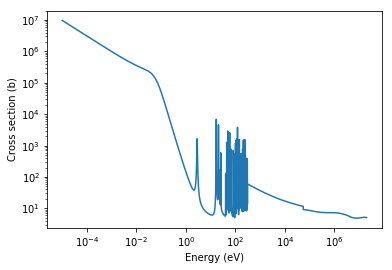

In [12]:
energies = gd157.energy['294K']
total_xs = total.xs['294K'](energies)
plt.loglog(energies, total_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

### Reaction Data

Most of the interesting data for an `IncidentNeutron` instance is contained within the `reactions` attribute, which is a dictionary mapping MT values to `Reaction` objects.

In [13]:
pprint(list(gd157.reactions.values())[:10])

[<Reaction: MT=1 (n,total)>,
 <Reaction: MT=101 (n,disappear)>,
 <Reaction: MT=301 heating>,
 <Reaction: MT=2 (n,elastic)>,
 <Reaction: MT=16 (n,2n)>,
 <Reaction: MT=17 (n,3n)>,
 <Reaction: MT=22 (n,na)>,
 <Reaction: MT=24 (n,2na)>,
 <Reaction: MT=28 (n,np)>,
 <Reaction: MT=41 (n,2np)>]


Let's suppose we want to look more closely at the (n,2n) reaction. This reaction has an energy threshold

In [14]:
n2n = gd157[16]
print('Threshold = {} eV'.format(n2n.xs['294K'].x[0]))

Threshold = 6400881.0 eV


The (n,2n) cross section, like all basic cross sections, is represented by the `Tabulated1D` class. The energy and cross section values in the table can be directly accessed with the `x` and `y` attributes. Using the `x` and `y` has the nice benefit of automatically acounting for reaction thresholds.

In [15]:
n2n.xs

{'294K': <openmc.data.function.Tabulated1D at 0x1461b4d594e0>}

(6400881.0, 20000000.0)

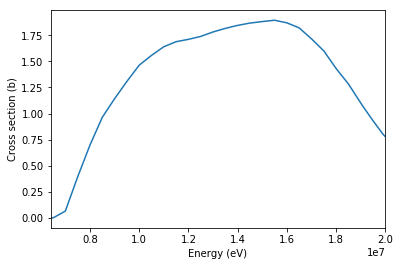

In [16]:
xs = n2n.xs['294K']
plt.plot(xs.x, xs.y)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.xlim((xs.x[0], xs.x[-1]))

To get information on the energy and angle distribution of the neutrons emitted in the reaction, we need to look at the `products` attribute.

In [17]:
n2n.products

[<Product: neutron, emission=prompt, yield=polynomial>,
 <Product: photon, emission=prompt, yield=tabulated>]

In [18]:
neutron = n2n.products[0]
neutron.distribution

We see that the neutrons emitted have a correlated angle-energy distribution. Let's look at the `energy_out` attribute to see what the outgoing energy distributions are.

In [19]:
dist = neutron.distribution[0]
dist.energy_out

Here we see we have a tabulated outgoing energy distribution for each incoming energy. Note that the same probability distribution classes that we could use to create a source definition are also used within the `openmc.data` package. Let's plot every fifth distribution to get an idea of what they look like.

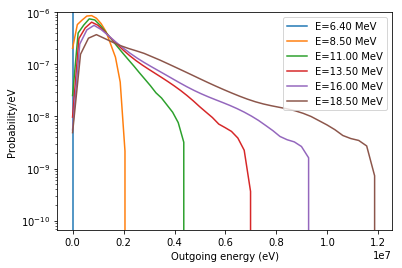

In [20]:
for e_in, e_out_dist in zip(dist.energy[::5], dist.energy_out[::5]):
    plt.semilogy(e_out_dist.x, e_out_dist.p, label='E={:.2f} MeV'.format(e_in/1e6))
plt.ylim(top=1e-6)
plt.legend()
plt.xlabel('Outgoing energy (eV)')
plt.ylabel('Probability/eV')
plt.show()

### Unresolved resonance probability tables

We can also look at unresolved resonance probability tables which are stored in a `ProbabilityTables` object. In the following example, we'll create a plot showing what the total cross section probability tables look like as a function of incoming energy.

Text(0, 0.5, 'Cross section(b)')

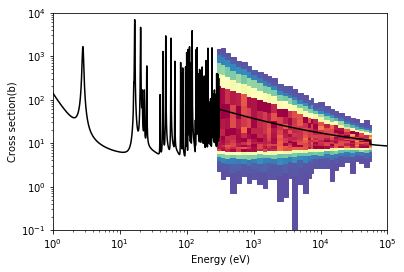

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm = matplotlib.cm.Spectral_r

# Determine size of probability tables
urr = gd157.urr['294K']
n_energy = urr.table.shape[0]
n_band = urr.table.shape[2]

for i in range(n_energy):
    # Get bounds on energy
    if i > 0:
        e_left = urr.energy[i] - 0.5*(urr.energy[i] - urr.energy[i-1])
    else:
        e_left = urr.energy[i] - 0.5*(urr.energy[i+1] - urr.energy[i])

    if i < n_energy - 1:
        e_right = urr.energy[i] + 0.5*(urr.energy[i+1] - urr.energy[i])
    else:
        e_right = urr.energy[i] + 0.5*(urr.energy[i] - urr.energy[i-1])
        
    for j in range(n_band):
        # Determine maximum probability for a single band
        max_prob = np.diff(urr.table[i,0,:]).max()
        
        # Determine bottom of band
        if j > 0:
            xs_bottom = urr.table[i,1,j] - 0.5*(urr.table[i,1,j] - urr.table[i,1,j-1])
            value = (urr.table[i,0,j] - urr.table[i,0,j-1])/max_prob
        else:
            xs_bottom = urr.table[i,1,j] - 0.5*(urr.table[i,1,j+1] - urr.table[i,1,j])
            value = urr.table[i,0,j]/max_prob

        # Determine top of band
        if j < n_band - 1:
            xs_top = urr.table[i,1,j] + 0.5*(urr.table[i,1,j+1] - urr.table[i,1,j])
        else:
            xs_top = urr.table[i,1,j] + 0.5*(urr.table[i,1,j] - urr.table[i,1,j-1])
    
        # Draw rectangle with appropriate color
        ax.add_patch(Rectangle((e_left, xs_bottom), e_right - e_left, xs_top - xs_bottom,
                     color=cm(value)))

# Overlay total cross section
ax.plot(gd157.energy['294K'], total.xs['294K'](gd157.energy['294K']), 'k')

# Make plot pretty and labeled
ax.set_xlim(1.0, 1.0e5)
ax.set_ylim(1e-1, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Cross section(b)')

### Exporting HDF5 data

If you have an instance `IncidentNeutron` that was created from ACE or HDF5 data, you can easily write it to disk using the `export_to_hdf5()` method. This can be used to convert ACE to HDF5 or to take an existing data set and actually modify cross sections.

In [22]:
gd157.export_to_hdf5('gd157.h5', 'w')

With few exceptions, the HDF5 file encodes the same data as the ACE file.

In [23]:
gd157_reconstructed = openmc.data.IncidentNeutron.from_hdf5('gd157.h5')
np.all(gd157[16].xs['294K'].y == gd157_reconstructed[16].xs['294K'].y)

True

And one of the best parts of using HDF5 is that it is a widely used format with lots of third-party support. You can use `h5py`, for example, to inspect the data.

In [24]:
h5file = h5py.File('gd157.h5', 'r')
main_group = h5file['Gd157/reactions']
for name, obj in sorted(list(main_group.items()))[:10]:
    if 'reaction_' in name:
        print('{}, {}'.format(name, obj.attrs['label'].decode()))

reaction_002, (n,elastic)
reaction_016, (n,2n)
reaction_017, (n,3n)
reaction_022, (n,na)
reaction_024, (n,2na)
reaction_028, (n,np)
reaction_041, (n,2np)
reaction_051, (n,n1)
reaction_052, (n,n2)
reaction_053, (n,n3)


In [25]:
n2n_group = main_group['reaction_016']
pprint(list(n2n_group.values()))

[<HDF5 group "/Gd157/reactions/reaction_016/294K" (1 members)>,
 <HDF5 group "/Gd157/reactions/reaction_016/product_0" (2 members)>,
 <HDF5 group "/Gd157/reactions/reaction_016/product_1" (2 members)>]


So we see that the hierarchy of data within the HDF5 mirrors the hierarchy of Python objects that we manipulated before.

In [26]:
n2n_group['294K/xs'][()]

array([0.000000e+00, 3.026796e-13, 1.291101e-02, 6.511110e-02,
       3.926270e-01, 5.752268e-01, 6.969600e-01, 7.399378e-01,
       9.635450e-01, 1.142130e+00, 1.308020e+00, 1.463500e+00,
       1.557600e+00, 1.640550e+00, 1.688960e+00, 1.711400e+00,
       1.739450e+00, 1.782070e+00, 1.816650e+00, 1.845280e+00,
       1.865409e+00, 1.867240e+00, 1.881558e+00, 1.881560e+00,
       1.881800e+00, 1.894470e+00, 1.869570e+00, 1.821200e+00,
       1.716000e+00, 1.600540e+00, 1.431620e+00, 1.283460e+00,
       1.101660e+00, 1.065300e+00, 9.307300e-01, 8.029800e-01,
       7.777400e-01])

### Working with ENDF files

In addition to being able to load ACE and HDF5 data, we can also load ENDF data directly into an `IncidentNeutron` instance using the `from_endf()` factory method. Let's download the ENDF/B-VII.1 evaluation for $^{157}$Gd and load it in:

In [27]:
# Download ENDF file
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/Gd/157'
filename, headers = urllib.request.urlretrieve(url, 'gd157.endf')

# Load into memory
gd157_endf = openmc.data.IncidentNeutron.from_endf(filename)
gd157_endf

<IncidentNeutron: Gd157>

Just as before, we can get a reaction by indexing the object directly:

In [28]:
elastic = gd157_endf[2]

However, if we look at the cross section now, we see that it isn't represented as tabulated data anymore.

In [29]:
elastic.xs

{'0K': <openmc.data.function.ResonancesWithBackground at 0x1461b11824a8>}

If had [Cython](http://cython.org/) installed when you built/installed OpenMC, you should be able to evaluate resonant cross sections from ENDF data directly, i.e., OpenMC will reconstruct resonances behind the scenes for you.

In [30]:
elastic.xs['0K'](0.0253)

998.7871174521487

When data is loaded from an ENDF file, there is also a special `resonances` attribute that contains resolved and unresolved resonance region data (from MF=2 in an ENDF file).

In [31]:
gd157_endf.resonances.ranges

We see that $^{157}$Gd has a resolved resonance region represented in the Reich-Moore format as well as an unresolved resonance region. We can look at the min/max energy of each region by doing the following:

In [32]:
[(r.energy_min, r.energy_max) for r in gd157_endf.resonances.ranges]

[(1e-05, 306.6), (306.6, 54881.1)]

With knowledge of the energy bounds, let's create an array of energies over the entire resolved resonance range and plot the elastic scattering cross section.

Text(0, 0.5, 'Cross section (b)')

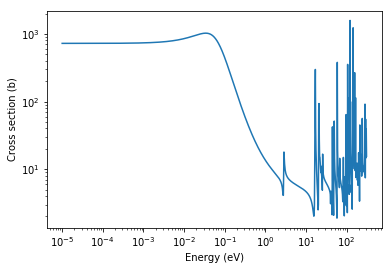

In [33]:
# Create log-spaced array of energies
resolved = gd157_endf.resonances.resolved
energies = np.logspace(np.log10(resolved.energy_min),
                       np.log10(resolved.energy_max), 1000)

# Evaluate elastic scattering xs at energies
xs = elastic.xs['0K'](energies)

# Plot cross section vs energies
plt.loglog(energies, xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

Resonance ranges also have a useful `parameters` attribute that shows the energies and widths for resonances.

In [34]:
resolved.parameters.head(10)

,energy,L,J,neutronWidth,captureWidth,fissionWidthA,fissionWidthB
0,0.0314,0,2.0,0.000474,0.1072,0.0,0.0
1,2.8250,0,2.0,0.000345,0.0970,0.0,0.0
2,16.2400,0,1.0,0.000400,0.0910,0.0,0.0
3,16.7700,0,2.0,0.012800,0.0805,0.0,0.0
4,20.5600,0,2.0,0.011360,0.0880,0.0,0.0
5,21.6500,0,2.0,0.000376,0.1140,0.0,0.0
6,23.3300,0,1.0,0.000813,0.1210,0.0,0.0
7,25.4000,0,2.0,0.001840,0.0850,0.0,0.0
8,40.1700,0,1.0,0.001307,0.1100,0.0,0.0
9,44.2200,0,2.0,0.008960,0.0960,0.0,0.0


## Heavy-nuclide resonance scattering

OpenMC has two methods for accounting for resonance upscattering in heavy nuclides, DBRC and RVS. These methods rely on 0 K elastic scattering data being present. If you have an existing ACE/HDF5 dataset and you need to add 0 K elastic scattering data to it, this can be done using the `IncidentNeutron.add_elastic_0K_from_endf()` method. Let's do this with our original `gd157` object that we instantiated from an ACE file.

In [35]:
gd157.add_elastic_0K_from_endf('gd157.endf')

Let's check to make sure that we have both the room temperature elastic scattering cross section as well as a 0K cross section.

In [36]:
gd157[2].xs

{'294K': <openmc.data.function.Tabulated1D at 0x1461b4d2ff60>,
 '0K': <openmc.data.function.Tabulated1D at 0x1461b0e59128>}

## Generating data from NJOY

To run OpenMC in continuous-energy mode, you generally need to have ACE files already available that can be converted to OpenMC's native HDF5 format. If you don't already have suitable ACE files or need to generate new data, both the `IncidentNeutron` and `ThermalScattering` classes include `from_njoy()` methods that will run [NJOY](https://www.njoy21.io/) to generate ACE files and then read those files to create OpenMC class instances. The `from_njoy()` methods take as input the name of an ENDF file on disk. By default, it is assumed that you have an executable named `njoy` available on your path. This can be configured with the optional `njoy_exec` argument. Additionally, if you want to show the progress of NJOY as it is running, you can pass `stdout=True`.

Let's use `IncidentNeutron.from_njoy()` to run NJOY to create data for $^2$H using an ENDF file. We'll specify that we want data specifically at 300, 400, and 500 K.

In [37]:
# Download ENDF file
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/H/2'
filename, headers = urllib.request.urlretrieve(url, 'h2.endf')

# Run NJOY to create deuterium data
h2 = openmc.data.IncidentNeutron.from_njoy('h2.endf', temperatures=[300., 400., 500.], stdout=True)


 njoy 2016.49  25Jan19                                       07/19/19 06:12:49
 *****************************************************************************

 reconr...                                                                0.0s

 broadr...                                                                0.1s
      300.0 deg                                                           0.1s
      400.0 deg                                                           0.2s
      500.0 deg                                                           0.3s

 heatr...                                                                 0.3s

 gaspr...                                                                 0.6s

 purr...                                                                  0.7s

 mat =  128                                                               0.7s

 ---message from purr---mat  128 has no resonance parameters
                          copy as is to nout

 acer...        

Now we can use our `h2` object just as we did before.

In [38]:
h2[2].xs

{'300K': <openmc.data.function.Tabulated1D at 0x1461b066ebe0>,
 '400K': <openmc.data.function.Tabulated1D at 0x1461b23a0978>,
 '500K': <openmc.data.function.Tabulated1D at 0x1461b1009400>,
 '0K': <openmc.data.function.Tabulated1D at 0x1461b101b358>}

Note that 0 K elastic scattering data is automatically added when using `from_njoy()` so that resonance elastic scattering treatments can be used.

## Windowed multipole

OpenMC can also be used with an experimental format called windowed multipole.  Windowed multipole allows for analytic on-the-fly Doppler broadening of the resolved resonance range.  Windowed multipole data can be downloaded with the `openmc-get-multipole-data` script.  This data can be used in the transport solver, but it can also be used directly in the Python API.

In [39]:
url = 'https://github.com/mit-crpg/WMP_Library/releases/download/v1.1/092238.h5'
filename, headers = urllib.request.urlretrieve(url, '092238.h5')

In [40]:
u238_multipole = openmc.data.WindowedMultipole.from_hdf5('092238.h5')

The `WindowedMultipole` object can be called with energy and temperature values.  Calling the object gives a tuple of 3 cross sections: elastic scattering, radiative capture, and fission.

In [41]:
u238_multipole(1.0, 294)

(array(9.13284265), array(0.50530278), array(2.9316765e-06))

An array can be passed for the energy argument.

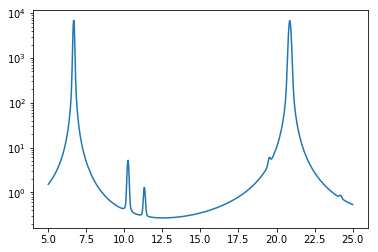

In [42]:
E = np.linspace(5, 25, 1000)
plt.semilogy(E, u238_multipole(E, 293.606)[1])

The real advantage to multipole is that it can be used to generate cross sections at any temperature.  For example, this plot shows the Doppler broadening of the 6.67 eV resonance between 0 K and 900 K.

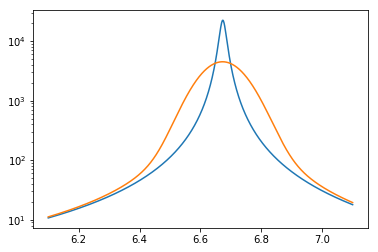

In [43]:
E = np.linspace(6.1, 7.1, 1000)
plt.semilogy(E, u238_multipole(E, 0)[1])
plt.semilogy(E, u238_multipole(E, 900)[1])